In [12]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score


import nqDataLoader as nq #data loading library

In [24]:
# Correct file path with extension
addedscores = pd.read_csv('data composite/scores composite.csv')

# Set 'pID' as the index
addedscores = addedscores.set_index('pID')

# Display the first few rows
addedscores

,gt,updrs108,afTap,sTap,nqScore,typingSpeed,file_1,file_2
pID,,,,,,,,
11,True,14.25,NaN,162.25,0.117543,189.372549,1402930351.011_001_014.csv,1403706430.011_003_014.csv
60,False,2.00,NaN,162.25,0.070350,60.533333,1402932300.060_001_014.csv,1403708258.060_003_014.csv
67,True,25.25,NaN,133.75,0.223411,54.333333,1401117235.067_001_014.csv,1401978395.067_003_014.csv
68,False,6.00,NaN,159.00,0.074973,71.800000,1401114972.068_001_014.csv,1401980765.068_003_014.csv
70,True,26.25,NaN,113.50,0.175751,39.614035,1404311419.070_001_014.csv,1404743687.070_003_014.csv
...,...,...,...,...,...,...,...,...
1063,False,0.00,110.0,170.00,-0.005529,109.800000,1463511198.1063_001_014.csv,NaN
1064,True,28.00,75.5,140.00,0.246866,105.333333,1458723488.1064_001_014.csv,NaN
1066,True,12.00,118.0,170.50,0.033189,140.250000,1460104760.1066_001_014.csv,NaN


In [28]:
# Concatenate the .csv files file_1 + file_2 par pID
data_folder = os.path.join("data composite", "data source composite")
output_folder = "concatenated_files"

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

for index, row in addedscores.iterrows():
    file_1 = os.path.join(data_folder, row['file_1'])
    file_2 = row['file_2']
    
    try:
        # Read the CSV file
        df1 = pd.read_csv(file_1)
        # Apply strip only to string (object) columns
        object_columns = df1.select_dtypes(['object']).columns
        df1[object_columns] = df1[object_columns].apply(lambda x: x.str.strip())
        
        if pd.notna(file_2):
            file_2 = os.path.join(data_folder, file_2)
            df2 = pd.read_csv(file_2)
            # Apply strip only to string (object) columns
            object_columns = df2.select_dtypes(['object']).columns
            df2[object_columns] = df2[object_columns].apply(lambda x: x.str.strip())
            
            # Concatenate dataframes
            concatenated_df = pd.concat([df1, df2], axis=0, ignore_index=True)
        else:
            concatenated_df = df1
        
        # Keep only the first four columns
        concatenated_df = concatenated_df.iloc[:, :4]

        # Save the concatenated DataFrame
        concatenated_df.to_csv(os.path.join(output_folder, f"{index}_combined.csv"), index=False)
    
    except FileNotFoundError as e:
        print(f"Error with pID {index}: {e}")


In [40]:
# In the combined.csv files, keep A to Z, 0 to 9 and space. Replace other entries by NaN
import pandas as pd
import os
import re

# Define the folders
source_folder = "concatenated_files"
output_folder = "refined_data"

# Create the output_folder if it does not exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# List all the .csv files in the source folder
csv_files = [file for file in os.listdir(source_folder) if file.endswith('.csv')]

# Define a regular expression pattern that matches the allowed entries
# This pattern looks for single characters a-z or digits 0-9, or the exact word 'space'
allowed_pattern = re.compile(r'^[a-z0-9]$|^space$')

# Function to replace unwanted entries with NaN
def clean_entry(entry):
    if pd.isna(entry):
        return entry
    str_entry = str(entry).strip().lower()  # Convert to lowercase to match the pattern
    if allowed_pattern.fullmatch(str_entry):
        return str_entry
    else:
        return "NaN"

# Process each CSV file
for csv_file in csv_files:
    input_file_path = os.path.join(source_folder, csv_file)

    output_file_name = csv_file.replace('combined', 'refined')
    output_file_path = os.path.join(output_folder, output_file_name)
    
    # Read the CSV file
    df = pd.read_csv(input_file_path)
    
    # Apply the function to clean the first column
    df.iloc[:, 0] = df.iloc[:, 0].apply(clean_entry)
    
    # Save the modified DataFrame to the new folder
    df.to_csv(output_file_path, index=False)

print("All files have been processed and saved in the 'refined_data' folder.")


All files have been processed and saved in the 'refined_data' folder.


In [43]:
# remove lines before the first 'space'
import pandas as pd
import os

# Define the folders
source_folder = "refined_data"  # The folder with the original refined data
destination_folder = "refined2_data"  # The folder for the second round of refined data

# Create the destination_folder if it does not exist
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# List all the .csv files in the source_folder
csv_files = [file for file in os.listdir(source_folder) if file.endswith('.csv')]

# Process each CSV file
for csv_file in csv_files:
    input_file_path = os.path.join(source_folder, csv_file)
    output_file_name = csv_file.replace('refined', 'refined2')
    output_file_path = os.path.join(destination_folder, output_file_name)
    
    # Read the CSV file without headers
    df = pd.read_csv(input_file_path, header=None)
    
    # Find the first occurrence of "space" in the first column
    first_space_index = df[df.iloc[:, 0] == 'space'].index.min()
    
    # Remove all rows above the first "space" entry
    df = df.loc[first_space_index:].reset_index(drop=True)
    
    # Save the modified DataFrame to the new folder
    df.to_csv(output_file_path, index=False, header=False)

print("All files have been processed and saved in the 'refined2_data' folder.")


All files have been processed and saved in the 'refined2_data' folder.


In [4]:
data = cs1PdFr
# Removing updrs108 score
# Direct correlation with target 
data = data[['gt', 'afTap', 'sTap', 'nqScore', 'typingSpeed']]
data = data.dropna()
data = data.replace([np.inf, -np.inf], np.nan).dropna()

In [6]:
X = data

has_nan = X.isna().any().any()

if has_nan:
    print("There are NaN values in the DataFrame 'X'.")
    # Dropping NaNs since these events do not have x and y coordinates
    X.dropna(inplace=True)
    X = X.reset_index(drop=True)
else:
    print("There are no NaN values in the DataFrame 'X'.")

X = X[~X.isin([np.nan, np.inf, -np.inf]).any(axis = 1)]
X = X.reset_index(drop=True)

X = data.drop('gt', axis=1)
y = data['gt']

num_cols = X.select_dtypes([np.number]).columns
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

categorical_cols = X.select_dtypes(exclude=["number", "bool"]).columns
X = pd.get_dummies(data=X, columns=categorical_cols)

boolean_cols = X.select_dtypes([bool]).columns
X[boolean_cols] = X[boolean_cols].astype(int)
X = X.reset_index(drop=True)

There are no NaN values in the DataFrame 'X'.


# DecisionTree with CV

In [ ]:

threshold_values = np.linspace(0.05,0.2,15)
k = len(threshold_values)

accuracy_scores = {}

for threshold in threshold_values:
    selected_features = X.columns[mutual_info_classif(X, y) >= threshold]
    if len(selected_features) > 0:
        X_selected = X[selected_features]
        model = DecisionTreeClassifier()
        cv_scores = cross_val_score(model, X_selected, y, cv=k, scoring='accuracy')
        accuracy = np.mean(cv_scores)
        accuracy_scores[threshold] = accuracy
    else:
        accuracy_scores[threshold] = 0

max_threshold = max(accuracy_scores, key=accuracy_scores.get)

print("Max threshold:")
print(max_threshold)
print("Max accuracy:")
print(accuracy_scores[max_threshold])

selected_features = X.columns[mutual_info_classif(X, y) >= max_threshold]
X_selected = X[selected_features]
# Training/test split = 3/4 to 1/4 ratio
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=0)
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

report = classification_report(y_test, y_pred)
print(report)

Max threshold:
0.08214285714285716
Max accuracy:
0.6888888888888888
              precision    recall  f1-score   support

       False       1.00      0.67      0.80         9
        True       0.40      1.00      0.57         2

    accuracy                           0.73        11
   macro avg       0.70      0.83      0.69        11
weighted avg       0.89      0.73      0.76        11



# LinearRegression with CV

In [ ]:
X = data.drop('gt', axis=1)
y = data['gt']

threshold_values = np.linspace(0.05,0.2,15)
k = len(threshold_values)

accuracy_scores = {}

for threshold in threshold_values:
    selected_features = X.columns[mutual_info_classif(X, y) >= threshold]
    if len(selected_features) > 0:
        X_selected = X[selected_features]
        model = LogisticRegression()
        cv_scores = cross_val_score(model, X_selected, y, cv=k, scoring='accuracy')
        accuracy = np.mean(cv_scores)
        accuracy_scores[threshold] = accuracy
    else:
        accuracy_scores[threshold] = 0

max_threshold = max(accuracy_scores, key=accuracy_scores.get)

print("Max threshold:")
print(max_threshold)
print("Max accuracy:")
print(accuracy_scores[max_threshold])

selected_features = X.columns[mutual_info_classif(X, y) >= max_threshold]
X_selected = X[selected_features]
# Training/test split = 3/4 to 1/4 ratio
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=0)
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

report = classification_report(y_test, y_pred)
print(report)

Max threshold:
0.05
Max accuracy:
0.7333333333333332
              precision    recall  f1-score   support

       False       1.00      0.78      0.88         9
        True       0.50      1.00      0.67         2

    accuracy                           0.82        11
   macro avg       0.75      0.89      0.77        11
weighted avg       0.91      0.82      0.84        11



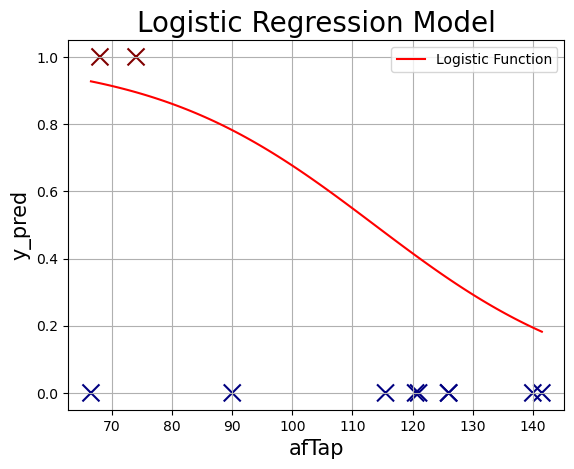

In [ ]:
#2D plot with ONE FEATURE

column = 'afTap'
N = 100
x_values = np.linspace(X_test[column].min(), X_test[column].max(), N)
y_values = 1 / (1 + np.exp(-(model.coef_[0][0] * x_values + model.intercept_)))

plt.scatter(X_test[column], y_test, c=y_test, cmap='jet', marker='x', s=150)
plt.plot(x_values, y_values, color='red', label='Logistic Function')
plt.xlabel(X_selected.columns[0], fontsize = 15)
plt.ylabel('y_pred', fontsize = 15)
plt.title('Logistic Regression Model', fontsize = 20)
plt.legend()
plt.grid()
plt.show()

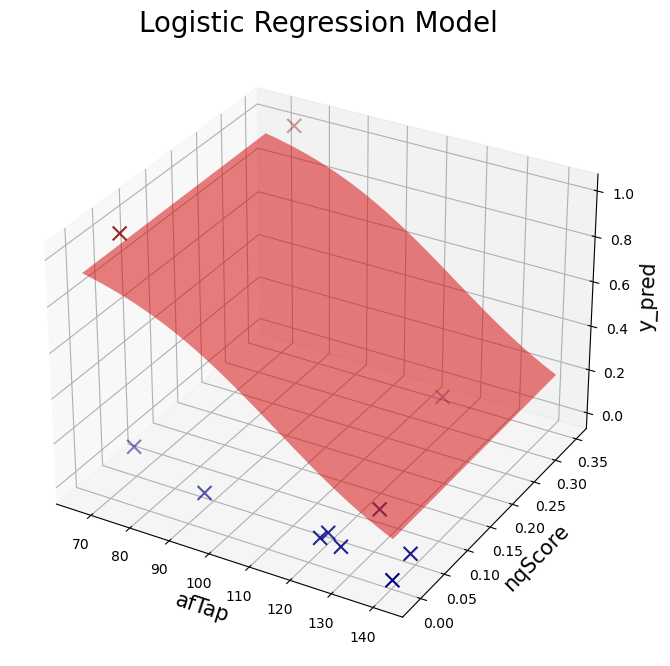

In [ ]:
# 3D plot with two features

N = 100
x_values = np.linspace(X_test.iloc[:, 0].min(), X_test.iloc[:, 0].max(), N)
y_values = np.linspace(X_test.iloc[:, 1].min(), X_test.iloc[:, 1].max(), N)
x_mesh, y_mesh = np.meshgrid(x_values, y_values)
z_values = 1 / (1 + np.exp(-(model.coef_[0][0] * x_mesh + model.coef_[0][1] * y_mesh + model.intercept_)))

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_test.iloc[:, 0], X_test.iloc[:, 1], y_test, c=y_test, cmap='jet', marker='x', s=100)
ax.plot_surface(x_mesh, y_mesh, z_values, color='red', alpha=0.5, rstride=100, cstride=100)
ax.set_xlabel(X_selected.columns[0], fontsize = 15)
ax.set_ylabel(X_selected.columns[1], fontsize = 15)
ax.set_zlabel('y_pred', fontsize = 15)
ax.set_title('Logistic Regression Model', fontsize = 20)
plt.show()

# Support Vector Machine with CV

In [ ]:
from sklearn.svm import SVC

X = data.drop('gt', axis=1)
y = data['gt']

threshold_values = np.linspace(0.05,0.2,15)
k = len(threshold_values)

accuracy_scores = {}

for threshold in threshold_values:
    selected_features = X.columns[mutual_info_classif(X, y) >= threshold]
    if len(selected_features) > 0:
        X_selected = X[selected_features]
        model = SVC(kernel='rbf', random_state=0)
        cv_scores = cross_val_score(model, X_selected, y, cv=k, scoring='accuracy')
        accuracy = np.mean(cv_scores)
        accuracy_scores[threshold] = accuracy
    else:
        accuracy_scores[threshold] = 0

max_threshold = max(accuracy_scores, key=accuracy_scores.get)

print("Max threshold:")
print(max_threshold)
print("Max accuracy:")
print(accuracy_scores[max_threshold])

selected_features = X.columns[mutual_info_classif(X, y) >= max_threshold]
X_selected = X[selected_features]
# Training/test split = 3/4 to 1/4 ratio
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=0)
model = SVC(kernel='rbf', random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

report = classification_report(y_test, y_pred)
print(report)

Max threshold:
0.05
Max accuracy:
0.7111111111111109
              precision    recall  f1-score   support

       False       1.00      0.67      0.80         9
        True       0.40      1.00      0.57         2

    accuracy                           0.73        11
   macro avg       0.70      0.83      0.69        11
weighted avg       0.89      0.73      0.76        11



Silhouette Score: 0.6037113446430525


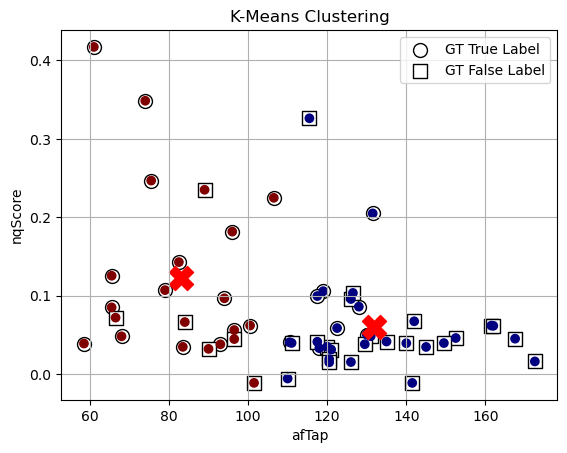

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


column1 = 'afTap'
column2 = 'nqScore'
X = data[[column1, column2]]
y = data['gt']
num_clusters = 2

kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)
labels = kmeans.labels_

silhouette_avg = silhouette_score(X, labels)
print(f"Silhouette Score: {silhouette_avg}")

# Visualize the clusters
plt.scatter(X[y][column1], X[y][column2], c='white', s=100, edgecolors='black', marker='o', label='GT True Label')
plt.scatter(X[~y][column1], X[~y][column2], c='white', s=100, edgecolors='black', marker='s', label='GT False Label')
plt.scatter(X[column1], X[column2], c=labels, cmap='jet')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', marker='X')
plt.xlabel(column1)
plt.ylabel(column2)
plt.title('K-Means Clustering')
plt.legend()
plt.grid()
plt.show()